In [29]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
import time
import warnings
import matplotlib.pyplot as plt

In [30]:
from autoimpute.imputations import MiceImputer,SingleImputer

In [31]:
from sklearn.impute import SimpleImputer

In [32]:
from statsmodels.imputation.mice import MICE
from statsmodels.imputation.mice import MICEData
import statsmodels.api as sm

In [33]:
# Set some debugging parameters
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [34]:
TRAINING_PERIOD = 4
LAG_PREDICTORS = True
NLAG = 1
DEPVAR = "asylum seekers"
# DEPVAR = "apprehensions"
# "asylum seekers" | "asylum seekers (global stock)" | "refugees (global stock)"
LOG_TRANSFORM_DEPVAR = True
PER_CAPITA_TRANSFORM_DEPVAR = True
SPEI_MOVING_AVERAGES_3_6 = False
NSTEP_AHEAD = 1
CALCULATE_INTERACTIONS = False

In [35]:
# Read Dataset directly from file and pre-process
# original_dataset = pd.read_csv("../Data/replication_data.csv")
# original_dataset = pd.read_csv("../RCode/imp.csv")
original_dataset = pd.read_csv("../../Data/USAAsylumApplications&UnauthorizedMigration/USA_cleaned_dataset.csv")
# original_dataset = pd.read_csv("../../Data/USAAsylumApplications&UnauthorizedMigration/global_cleaned_asylum_2000_2018.csv")
# original_dataset = pd.read_csv("../../Data/USAAsylumApplications&UnauthorizedMigration/USA_cleaned_apprehensions_2002_2018.csv")
# original_dataset['n_asylum'] = original_dataset['n_asylum'].fillna(0)
# original_dataset['n_asylum_eu28'] = original_dataset['n_asylum_eu28'].fillna(0)
original_dataset['US_apprehensions'] = original_dataset['US_apprehensions'].fillna(0)
original_dataset['US_asylum_applications'] = original_dataset['US_asylum_applications'].fillna(0)
# original_dataset['n_asylum_eu28'] = original_dataset['US_asylum_applications'].fillna(0)
# original_dataset['global_asylum_applications'] = original_dataset['global_asylum_applications'].fillna(0)
# original_dataset['n_refugees'] = original_dataset['n_refugees'].fillna(0)
original_dataset['spei3_gs_neg'] = original_dataset['spei3_gs_neg'].apply(lambda x: x*12)
original_dataset['spei3_gs_pos'] = original_dataset['spei3_gs_pos'].apply(lambda x: x*12)
original_dataset['physical_integrity'] = original_dataset['civil_liberties_combined']

In [36]:
# Remove all microstates from the list
microstates = pd.read_csv("../Data/microstates.dat", sep = "\t", names=['gwcode','iso3','name','d1','d2'])
microstates_list = microstates['gwcode'].to_list()
dataset = original_dataset[~original_dataset['gwcode'].isin(microstates_list)]
# dataset = original_dataset
dataset = dataset.reset_index()

In [37]:
# Original code did log(population+1),  I have directly did log population and inf values are 0
# USA
if DEPVAR == "asylum seekers":
    dataset['orig_depvar'] = dataset['US_asylum_applications']
#     dataset['orig_depvar'] = dataset['global_asylum_applications']
    dataset['ln_depvar_pop'] = dataset['US_asylum_applications']
#     dataset['ln_depvar_pop'] = dataset['global_asylum_applications']
    dataset.loc[dataset['US_asylum_applications']>0, 'ln_depvar_pop'] = dataset['US_asylum_applications']/(dataset['wdi_pop']/1e6) +1
    dataset.loc[dataset['US_asylum_applications']<=0, 'ln_depvar_pop'] = 1
#     dataset.loc[dataset['global_asylum_applications']>0, 'ln_depvar_pop'] = dataset['global_asylum_applications']/(dataset['wdi_pop']/1e6) +1
#     dataset.loc[dataset['global_asylum_applications']<=0, 'ln_depvar_pop'] = 1
    dataset['ln_depvar_pop'] = pd.to_numeric(dataset['ln_depvar_pop'])
    dataset['ln_depvar_pop'] = dataset['ln_depvar_pop'].apply(lambda x: np.log(x))

# US Apprehensions
if DEPVAR == "apprehensions":
    dataset['orig_depvar'] = dataset['US_apprehensions']
    dataset['ln_depvar_pop'] = dataset['US_apprehensions']
    dataset.loc[dataset['US_apprehensions']>0, 'ln_depvar_pop'] = (dataset['US_apprehensions']/(dataset['wdi_pop']/1e6)) +1
    dataset.loc[dataset['US_apprehensions']<=0, 'ln_depvar_pop'] = 1
    dataset['ln_depvar_pop'] = dataset['ln_depvar_pop'].apply(lambda x: np.log(x))

# # Has to be changed depending on what we are predicting
dataset['depvar'] = dataset['ln_depvar_pop']

In [38]:
impute_dataset = dataset[['country', 'year', 'depvar', 'highest_neighbor_dem', 'area', 'wdi_pop', 'wdi_urban_pop', 'min_distance', 'pop_distance','perc_rejected_asylum',\
                          'wdi_gdppc_growth', 'wdi_gdppc', 'perc_post_secondary', 'kof_index', 'wdi_imr',\
                          'tmp_pop', 'spei3_gs_pos', 'spei3_gs_neg', \
                          'casualties_brd', 'annually_affected_20k', 'physical_integrity', 'free_movement', 'homicide']]
    

In [39]:
impute_dataset.loc[impute_dataset['wdi_pop']>0, 'wdi_pop'] = impute_dataset['wdi_pop']
impute_dataset.loc[impute_dataset['wdi_pop']<=0, 'wdi_pop'] = 1
impute_dataset.loc[impute_dataset['wdi_gdppc']>0, 'wdi_gdppc'] = impute_dataset['wdi_gdppc']
impute_dataset.loc[impute_dataset['wdi_gdppc']<=0, 'wdi_gdppc'] = 1
impute_dataset.loc[impute_dataset['casualties_brd']>0, 'casualties_brd'] = impute_dataset['casualties_brd']
impute_dataset.loc[impute_dataset['casualties_brd']<=0, 'casualties_brd'] = 1
impute_dataset.loc[impute_dataset['annually_affected_20k']>0, 'annually_affected_20k'] = impute_dataset['annually_affected_20k']
impute_dataset.loc[impute_dataset['annually_affected_20k']<=0, 'annually_affected_20k'] = 1
impute_dataset.loc[impute_dataset['homicide']>0, 'homicide'] = impute_dataset['homicide']
impute_dataset.loc[impute_dataset['homicide']<=0, 'homicide'] = 1

In [40]:
impute_dataset['wdi_pop'] = impute_dataset['wdi_pop'].apply(lambda x: np.log(x))
impute_dataset['area'] = impute_dataset['area'].apply(lambda x: np.log(x))
impute_dataset['wdi_gdppc'] = impute_dataset['wdi_gdppc'].apply(lambda x: np.log(x))
impute_dataset['casualties_brd'] = impute_dataset['casualties_brd'].apply(lambda x: np.log(x))
impute_dataset['annually_affected_20k'] = impute_dataset['annually_affected_20k'].apply(lambda x: np.log(x))
impute_dataset['homicide'] = impute_dataset['homicide'].apply(lambda x: np.log(x))

In [41]:
# Second order tmp_pop
# impute_dataset['tmp_pop_sq'] = impute_dataset['tmp_pop'].apply(lambda x: np.power(x,2))

# impute_dataset['spei3_gs_pos'] = -1*impute_dataset['spei3_gs_pos']
# impute_dataset['spei3_gs_neg'] = -1*impute_dataset['spei3_gs_neg']

# 3 year moving average
impute_dataset['spei3_gs_pos_r3'] = impute_dataset['spei3_gs_pos'].rolling(3,min_periods=1).mean()
impute_dataset['spei3_gs_neg_r3'] = impute_dataset['spei3_gs_neg'].rolling(3,min_periods=1).mean()
# 6 year moving average
# impute_dataset['spei3_gs_pos_r6'] = impute_dataset['spei3_gs_pos'].rolling(6,min_periods=1).mean()
# impute_dataset['spei3_gs_neg_r6'] = impute_dataset['spei3_gs_neg'].rolling(6,min_periods=1).mean()


In [42]:
# Filter for only years we want
if DEPVAR == "asylum seekers":
    impute_dataset = impute_dataset[impute_dataset['year']>=2007]
elif DEPVAR == "apprehensions":
    impute_dataset = impute_dataset[impute_dataset['year']>=1999]

In [43]:
# Global imputation parameters
n_imputations = 1 # number of imputations
impute_dataset = impute_dataset.replace([np.inf, -np.inf], np.nan).reset_index()
# impute_dataset = impute_dataset.replace(0, np.nan).reset_index()
imputations = []
# print(impute_dataset)

In [44]:
# Statsmodel based imputation
c = impute_dataset['country']
y = impute_dataset['year']
impute_dataset = impute_dataset.drop(columns=['country','year'])
imp = MICEData(impute_dataset)
fml = 'depvar ~ highest_neighbor_dem+area+wdi_pop+wdi_urban_pop+min_distance+pop_distance+perc_rejected_asylum+wdi_gdppc_growth+wdi_gdppc+perc_post_secondary+kof_index+wdi_imr+tmp_pop+spei3_gs_pos+spei3_gs_neg+casualties_brd+annually_affected_20k+physical_integrity+free_movement+homicide'
mice = MICE(fml, sm.OLS, imp)
results = mice.fit(10, n_imputations)
for j in range(n_imputations):
    print(j)
    imp.update_all()
    temp = imp.data
    temp['country'] = c
    temp['year'] = y
    
    # Constraint on imputation values
    temp.loc[temp['spei3_gs_neg']<=0, 'spei3_gs_neg'] = 0
    temp.loc[temp['spei3_gs_pos']<=0, 'spei3_gs_pos'] = 0
    temp.loc[temp['kof_index']<=0, 'kof_index'] = 0
    temp.loc[temp['wdi_urban_pop']<=0, 'wdi_urban_pop'] = 0
    temp.loc[temp['perc_post_secondary']<=0, 'perc_post_secondary'] = 0
    temp.loc[temp['wdi_imr']<=0, 'wdi_imr'] = 0
    temp.loc[temp['min_distance']<=0, 'min_distance'] = 0
    temp.loc[temp['pop_distance']<=0, 'pop_distance'] = 0

    imputations.append(temp)
    
# impute_dataset = imputations[0]
# print(impute_dataset)
len(imputations)

0


1

In [45]:
#Construct year slices -  as this is predictor variable lag - 1998 predicts 1999
if DEPVAR == "asylum seekers":
    year_range = [2007,2017]
elif DEPVAR == "apprehensions":
    year_range = [1999,2017]

window = 4
step_ahead = 1
slices = []
for i in range(year_range[0],year_range[1]-window+1):
    slices.append(([j for j in range(i,i+window)],i+window-1+step_ahead))

print(slices)
plot_slices = [s[1] for s in slices]
print(plot_slices)

[([2007, 2008, 2009, 2010], 2011), ([2008, 2009, 2010, 2011], 2012), ([2009, 2010, 2011, 2012], 2013), ([2010, 2011, 2012, 2013], 2014), ([2011, 2012, 2013, 2014], 2015), ([2012, 2013, 2014, 2015], 2016), ([2013, 2014, 2015, 2016], 2017)]
[2011, 2012, 2013, 2014, 2015, 2016, 2017]


In [46]:
baseline_columns = ['highest_neighbor_dem', 'area', 'wdi_pop', 'wdi_urban_pop', 'min_distance','pop_distance','perc_rejected_asylum']
economy_columns = ['wdi_gdppc_growth', 'wdi_gdppc', 'perc_post_secondary', 'kof_index', 'wdi_imr']
climate_columns = ['tmp_pop', 'spei3_gs_pos', 'spei3_gs_neg','spei3_gs_pos_r3','spei3_gs_neg_r3']#,'tmp_pop_sq']
# climate_columns = ['tmp_pop', 'spei3_gs_pos', 'spei3_gs_neg']
violence_columns = ['casualties_brd', 'annually_affected_20k', 'physical_integrity', 'free_movement', 'homicide']
# violence_columns = ['casualties_brd', 'annually_affected_20k']#, 'physical_integrity', 'free_movement', 'homicide']

In [47]:
to_drop = [
    [economy_columns+climate_columns,"Violence"], #only violence+baseline
# ['casualties_brd', 'annually_affected_20k','physical_integrity', 'free_movement', 'homicide']
    [economy_columns+violence_columns,"Climate"], #only climate+baseline
    [climate_columns+violence_columns,"Economy"], #only economy+baseline
    [[],"All"]                               #all
#     economy_columns+violence_columns+climate_columns #only baseline
]

In [48]:
line_plot_mae = {"Violence":[],"Climate":[],"Economy":[],"All":[]}
line_plot_absolute = {"Violence":[],"Climate":[],"Economy":[],"All":[]}
line_plot_gt = {"Violence":[],"Climate":[],"Economy":[],"All":[]}
# temp_years = {}
# for y in plot_slices:
#     temp_years[y] = []
means_all = {"Violence":{y:[] for y in plot_slices},
             "Climate":{y:[] for y in plot_slices},
             "Economy":{y:[] for y in plot_slices},
             "All":{y:[] for y in plot_slices}}
print(means_all)

{'Violence': {2011: [], 2012: [], 2013: [], 2014: [], 2015: [], 2016: [], 2017: []}, 'Climate': {2011: [], 2012: [], 2013: [], 2014: [], 2015: [], 2016: [], 2017: []}, 'Economy': {2011: [], 2012: [], 2013: [], 2014: [], 2015: [], 2016: [], 2017: []}, 'All': {2011: [], 2012: [], 2013: [], 2014: [], 2015: [], 2016: [], 2017: []}}


In [49]:
x = ["Violence","Climate","Economy","All"]
y = []
all_predictions = []
for dropped in to_drop:
    avg_tot_mae = 0
    for impute_dataset in imputations:
        
        grouped_countries = impute_dataset.groupby(['country'])
        # Lag the dataset
        lagged_frame_original = pd.DataFrame()
        for country, feats in grouped_countries:
            features = grouped_countries.get_group(country).sort_values(by='year')
#             print(grouped_countries.get_group(country).sort_values(by='n_asylum_28'))
            features['depvar'] = features['depvar'].shift(-1)
            features = features[:-1] # to lag 
            lagged_frame_original = pd.concat([lagged_frame_original,features])
        
#         to_scaler_feat = lagged_frame_original.drop(columns=['country','year','depvar']+dropped[0]).to_numpy()
#         to_scaler_lbl = lagged_frame_original.drop(columns=['depvar']).to_numpy()
#         ss = StandardScaler(with_mean=True,with_std=True)
#         ss.fit(to_scaler_feat,to_scaler_lbl)
#         m,v = ss.mean_,ss.var_
#         sc = np.sqrt(v)
#         print(to_scaler_feat.shape)
#         print(m.shape)
#         print(v.shape)
        
        
        avg_mae = 0
#         clf = RandomForestRegressor(n_estimators=1000, min_samples_split=5)
        for idx in range(len(slices)):
            s = slices[idx]
            print(idx+1,"/",len(slices))
            lagged_frame = lagged_frame_original.drop(columns=dropped[0])

            train_set = lagged_frame.loc[lagged_frame['year'].isin(s[0])]
            train_features = train_set.drop(columns=['country','year','depvar','index']).to_numpy()
            all_col_lbls = train_set.drop(columns=['country','year','depvar','index']).columns.values
            print(all_col_lbls)
            train_targets = train_set['depvar'].to_numpy()
#             scaler_train = StandardScaler(with_mean=True,with_std=True)
#             scaler_train.mean_ = m
#             scaler_train.var_ = v
#             scaler_train.scale_ = sc
#             print(train_features.shape)
#             train_features = scaler_train.fit_transform(train_features,train_targets)
#             train_features = scaler_train.transform(train_features)

            test_set = lagged_frame.loc[lagged_frame['year'] == s[1]]
#             print(test_set)
            test_features = test_set.drop(columns=['country','year','depvar','index']).to_numpy()
            test_targets = test_set['depvar'].to_numpy()
#             scaler_test = StandardScaler(with_mean=True,with_std=True)
#             scaler_test.mean_ = m
#             scaler_test.var_ = v
#             scaler_test.scale_ = sc
#             test_features = scaler_test.fit_transform(test_features)
#             test_features = scaler_train.transform(test_features)

            clf = RandomForestRegressor(n_estimators=1000, min_samples_split=5)
#             clf = LinearRegression()
            clf.fit(train_features,train_targets)
            predictions = clf.predict(test_features)
#             for p in predictions:
#                 all_predictions.append((s[1],np.exp(p)))
            new_pred = []
            new_test = []
            cnt=0
            for i in range(len(predictions)):
                new_pred.append(predictions[i])
                new_test.append(test_targets[i])
#             print(new_pred)
#             print(new_test)
            mae = mean_absolute_error(new_test,new_pred)
#             print(set(zip(np.exp((new_pred)*(test_set['wdi_pop']/1e6)),np.exp((new_test)*(test_set['wdi_pop']/1e6)))))
            print("MAE for this run: ",mae)
            line_plot_mae[dropped[1]].append(mae)
            means_all[dropped[1]][s[1]].append(mae)
#             print(means_all)
            country_multipliers = (np.exp(test_set['wdi_pop'])/1e6).to_numpy()
#             print(country_multipliers)
            original_var_cumm = np.multiply(country_multipliers,(np.exp(new_test)))
            predicted_var_cumm = np.multiply(country_multipliers,(np.exp(new_pred)))
            original_depvar = np.array(new_test)
            predicted_depvar = np.array(new_pred)
            idx_orig = np.argsort(-original_var_cumm)[:5]
            vals_orig = np.sort(-original_var_cumm)[:5]
            idx_pred = np.argsort(-predicted_var_cumm)[:5]
            vals_pred = np.sort(-predicted_var_cumm)[:5]
            depvar_orig = np.sort(-original_depvar)[:5]
            depvar_pred = np.sort(-predicted_depvar)[:5]
            mm = test_set['country'].reset_index()
            print("Predicted:",predicted_var_cumm.sum(),"Original",original_var_cumm.sum())
            print("Feature importance",list(zip(all_col_lbls,clf.feature_importances_)))
            print("Original",list(zip(mm.iloc[idx_orig]['country'].to_numpy(),list(-vals_orig),list(-depvar_orig),country_multipliers[idx_orig])))
            print("Predicted",list(zip(mm.iloc[idx_pred]['country'].to_numpy(),list(-vals_pred),list(-depvar_pred),country_multipliers[idx_pred])))
            print()

            line_plot_absolute[dropped[1]].append(np.multiply(country_multipliers,(np.exp(new_pred))).sum())
            line_plot_gt[dropped[1]].append(np.multiply(country_multipliers,(np.exp(new_test))).sum())
#             line_plot_gt[dropped[1]].append(np.exp(new_test).sum())
            avg_mae+=mae
            
        print("Average MAE for this imputation: ",avg_mae/len(slices))
        avg_tot_mae += avg_mae/len(slices)
#     break
    print("Average MAE for all imputations:",avg_tot_mae/n_imputations)#," Dropped cols: ",dropped)
    y.append(avg_tot_mae/n_imputations)

1 / 7
['highest_neighbor_dem' 'area' 'wdi_pop' 'wdi_urban_pop' 'min_distance'
 'pop_distance' 'perc_rejected_asylum' 'casualties_brd'
 'annually_affected_20k' 'physical_integrity' 'free_movement' 'homicide']
MAE for this run:  0.36612543328829655
Predicted: 21280.49621778482 Original 29296.124183222695
Feature importance [('highest_neighbor_dem', 0.035053959602076565), ('area', 0.035772603729717536), ('wdi_pop', 0.1329685921538406), ('wdi_urban_pop', 0.05932065529702065), ('min_distance', 0.09807775250903344), ('pop_distance', 0.2534647045200519), ('perc_rejected_asylum', 0.072338158663247), ('casualties_brd', 0.004960828911710399), ('annually_affected_20k', 0.005115635120862522), ('physical_integrity', 0.054511910338302494), ('free_movement', 0.06003426416658892), ('homicide', 0.18838093498754793)]
Original [('mexico', 4896.461210838829, 6.398393846923348, 115.69547300000002), ('el salvador', 3731.800873619352, 5.281101060199642, 6.210567999999994), ('china', 2986.110239802474, 5.1583

MAE for this run:  0.4558072174076483
Predicted: 63990.309129881614 Original 114564.14185074018
Feature importance [('highest_neighbor_dem', 0.0348644972533481), ('area', 0.04487932925562594), ('wdi_pop', 0.05775446937171434), ('wdi_urban_pop', 0.06610520932629323), ('min_distance', 0.17714326517450824), ('pop_distance', 0.17179555339361108), ('perc_rejected_asylum', 0.004632296184682143), ('casualties_brd', 0.006829863116932521), ('annually_affected_20k', 0.008584754538826723), ('physical_integrity', 0.04139089939366784), ('free_movement', 0.03939995792397056), ('homicide', 0.3466199050668193)]
Original [('el salvador', 25408.66718872498, 8.28840529422446, 6.3881219999999965), ('guatemala', 23083.975557445927, 7.586909002752796, 16.914935999999983), ('honduras', 18595.97480522869, 7.218696938376158, 9.429012999999998), ('mexico', 14293.278083310603, 5.053053481580959, 124.77732400000018), ('india', 8075.4132009362465, 4.969202653102259, 1338.6588350000025)]
Predicted [('mexico', 15580

MAE for this run:  0.47059059228745886
Predicted: 46799.257656393005 Original 128317.70694265568
Feature importance [('highest_neighbor_dem', 0.029817653169255616), ('area', 0.049530447185993705), ('wdi_pop', 0.05984124829919382), ('wdi_urban_pop', 0.07628486421346606), ('min_distance', 0.28400160686868564), ('pop_distance', 0.3851139919640505), ('perc_rejected_asylum', 0.036689406276080416), ('tmp_pop', 0.0331675958579934), ('spei3_gs_pos', 0.004249642234789833), ('spei3_gs_neg', 0.006464680860092952), ('spei3_gs_pos_r3', 0.01598315222504745), ('spei3_gs_neg_r3', 0.018855710845350482)]
Original [('el salvador', 37123.61196122014, 8.672586740308013, 6.3561429999999985), ('guatemala', 22608.45302864785, 7.7333846442694405, 16.583060000000017), ('honduras', 21168.167107901467, 7.217697450757091, 9.270794999999998), ('mexico', 15103.945130873026, 6.087548669761916, 123.33337599999999), ('haiti', 4773.279616429551, 5.062666899941733, 10.839969999999989)]
Predicted [('mexico', 8873.90307898

MAE for this run:  0.35870124148458
Predicted: 31068.260391198597 Original 86476.41868523922
Feature importance [('highest_neighbor_dem', 0.02088301515590618), ('area', 0.052461969095719214), ('wdi_pop', 0.05459430586029598), ('wdi_urban_pop', 0.03795251170806401), ('min_distance', 0.14541376600475975), ('pop_distance', 0.3631484747696837), ('perc_rejected_asylum', 0.020833884154673667), ('wdi_gdppc_growth', 0.013718116181925042), ('wdi_gdppc', 0.18875475697869298), ('perc_post_secondary', 0.03809070553067692), ('kof_index', 0.038231782753649496), ('wdi_imr', 0.025916711805953046)]
Original [('el salvador', 23371.738948075403, 8.214753195017169, 6.325124), ('guatemala', 14211.472227758506, 7.295743778432442, 16.252429000000017), ('honduras', 13432.555123059903, 6.773562446246111, 9.112915999999993), ('mexico', 13199.550243728183, 4.813401802061008, 121.85825800000009), ('india', 4053.094125499677, 4.685079485923705, 1310.1524029999998)]
Predicted [('mexico', 5090.0713340900775, 6.40073

MAE for this run:  0.3384074204185841
Predicted: 24413.696049817823 Original 38046.19119056025
Feature importance [('highest_neighbor_dem', 0.018977642552996072), ('area', 0.041329347573141516), ('wdi_pop', 0.060156709064891636), ('wdi_urban_pop', 0.020760830027132103), ('min_distance', 0.06896006145395454), ('pop_distance', 0.24412805088591746), ('perc_rejected_asylum', 0.019963491660194368), ('wdi_gdppc_growth', 0.009612573798656439), ('wdi_gdppc', 0.1429588661248298), ('perc_post_secondary', 0.038724700334764835), ('kof_index', 0.026143065134311926), ('wdi_imr', 0.019036932346093573), ('tmp_pop', 0.02653328059354714), ('spei3_gs_pos', 0.0036261328016407805), ('spei3_gs_neg', 0.0032048334460546392), ('casualties_brd', 0.00258107436826682), ('annually_affected_20k', 0.0027445715857685794), ('physical_integrity', 0.01917242723666573), ('free_movement', 0.017975995515078346), ('homicide', 0.19103308621672244), ('spei3_gs_pos_r3', 0.011117971602701301), ('spei3_gs_neg_r3', 0.011258355676

MAE for this run:  0.48031743615375483
Predicted: 61593.15228034389 Original 114564.14185074018
Feature importance [('highest_neighbor_dem', 0.015327810745498972), ('area', 0.035482198896558015), ('wdi_pop', 0.03406207616470399), ('wdi_urban_pop', 0.044527184982116566), ('min_distance', 0.15183393447908283), ('pop_distance', 0.14215585265469158), ('perc_rejected_asylum', 0.0020524763826670974), ('wdi_gdppc_growth', 0.010506796318189016), ('wdi_gdppc', 0.09722776115058791), ('perc_post_secondary', 0.01727655046683384), ('kof_index', 0.02855195418985344), ('wdi_imr', 0.023164517326654453), ('tmp_pop', 0.018813378463894977), ('spei3_gs_pos', 0.004488795958039334), ('spei3_gs_neg', 0.0029789739164698447), ('casualties_brd', 0.004243664296541144), ('annually_affected_20k', 0.004417185587570483), ('physical_integrity', 0.023172142384893846), ('free_movement', 0.014885615182837392), ('homicide', 0.2971717754165612), ('spei3_gs_pos_r3', 0.011260793899446363), ('spei3_gs_neg_r3', 0.016398561136

In [50]:
year_mean = [[np.mean(means_all[lbl][y]) for y in means_all[lbl]] for lbl in means_all]
year_std = [[np.std(means_all[lbl][y]) for y in means_all[lbl]] for lbl in means_all]
print(year_mean)
print(year_std)

[[0.36612543328829655, 0.3555047628133021, 0.3462830108476456, 0.32390014136574213, 0.391777081902507, 0.45909928036815106, 0.4558072174076483], [0.4039639447451615, 0.39206318914410404, 0.3342113071628781, 0.3610939481947814, 0.4448503266299565, 0.47059059228745886, 0.42997969402629277], [0.3470386801597697, 0.3645856214161702, 0.31057063401015644, 0.3255811711559129, 0.35870124148458, 0.3955858362295392, 0.3968388392621753], [0.36773323320156953, 0.39097150988292856, 0.3384074204185841, 0.3281876259731255, 0.40593627782841396, 0.4675818394102094, 0.48031743615375483]]
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


Text(0.5, 1.0, 'Global - MAE of RF model predictions (apprehensions)')

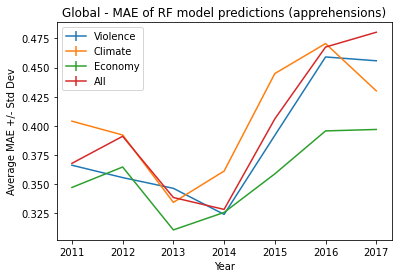

In [51]:
plt.errorbar(plot_slices,year_mean[0],yerr=year_std[0],label="Violence")
plt.errorbar(plot_slices,year_mean[1],yerr=year_std[1],label="Climate")
plt.errorbar(plot_slices,year_mean[2],yerr=year_std[2],label="Economy")
plt.errorbar(plot_slices,year_mean[3],yerr=year_std[3],label="All")
plt.legend(loc="upper left")
plt.xlabel("Year")
plt.ylabel("Average MAE +/- Std Dev")
plt.title("Global - MAE of RF model predictions (apprehensions)")
# plt.savefig('Global-MAE asylum applications.png')

In [52]:
x = ["Violence","Climate","Economy","All"]
y = [round(y_,2) for y_ in y]

[Text(0, 0, '0.39'), Text(0, 0, '0.41'), Text(0, 0, '0.36'), Text(0, 0, '0.4')]

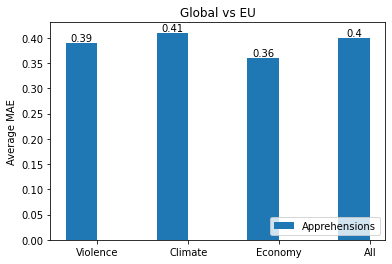

In [53]:
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(x)) - width/2, y, width, label='Apprehensions')
# rects2 = ax.bar(np.arange(len(x)) + width/2, y_gt, width, label='Original (EU)')

ax.set_ylabel('Average MAE')
ax.set_title('Global vs EU')
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x)
ax.legend(loc = "lower right")

ax.bar_label(rects1, padding=0)
# ax.bar_label(rects2, padding=0)


# plt.savefig('Global vs EU average MAE - RF fit')

Text(0.5, 0, 'Year')

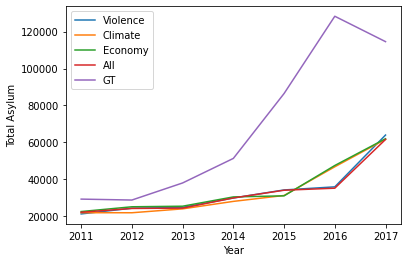

In [54]:
for lbl in x:
    f = []
#     print(len(line_plot_absolute[lbl]),len(plot_slices))
    mult = int(len(line_plot_absolute[lbl])/len(plot_slices))
    for i in range(0,len(slices)):
        f.append(np.mean(line_plot_absolute[lbl][i*mult:(i+1)*mult]))
#     print(len(f))
    plt.plot(plot_slices,f,label=lbl)
plt.plot(plot_slices,line_plot_gt["Violence"][:len(plot_slices)],label="GT")
plt.legend(loc="upper left")
plt.ylabel('Total Asylum')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

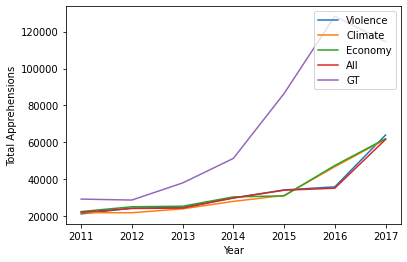

In [55]:
plt.plot(plot_slices,line_plot_absolute["Violence"],label="Violence")
plt.plot(plot_slices,line_plot_absolute["Climate"],label="Climate")
plt.plot(plot_slices,line_plot_absolute["Economy"],label="Economy")
plt.plot(plot_slices,line_plot_absolute["All"],label="All")
plt.plot(plot_slices,line_plot_gt["All"],label="GT")
plt.legend(loc="upper right")
plt.ylabel('Total Apprehensions')
plt.xlabel('Year')